## Goal of this analysis: check OLS linear regression assumptions
- This notebook verifies a few key assumptions on which ordinary least squares linear regression is based
- See ols_linear_regression.ipynb for a step-by-step approach to building a simple model

### The following assumptions are verified:
- non-uniqueness of predictor values
- normality and unbiasedness of residuals
- homoscedasticity of predictors
- zero correlation among predictor variables


## Import external libraries

In [1]:
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

## Import custom functions from functions.py

In [2]:
import functions as func

## 1. Read Data
Read training data from CSV files provided by Kaggle.

In [3]:
print('1. Reading data...\n')
thisDirectory = os.getcwd()

data = pd.read_csv(thisDirectory + "/Data/train.csv", parse_dates=True, index_col=0)

1. Reading data...



## 2. Prepare data: train-test-split


In [4]:
print('2. Preparing data...\n')
y = data['count']
data.drop(columns=['count','casual','registered'], inplace = True)

X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=42)

2. Preparing data...



## 3. Feature engineer




### Columns of the model:

['yr_2012', 'mon_2', 'mon_3', 'mon_4', 'mon_5', 'mon_6', 'mon_7',
       'mon_8', 'mon_9', 'mon_10', 'mon_11', 'mon_12', 'hr_1', 'hr_2', 'hr_3',
       'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'humidity', 'windspeed', 'atemp',
       'weather', 'workingday', 'hr_1_workingday', 'hr_8_workingday',
       'hr_13_workingday', 'hr_14_workingday', 'hr_15_workingday',
       'hr_16_workingday', 'hr_18_workingday', 'hr_21_workingday',
       'windspeed_Sq', 'humidity_Sq', 'atemp_Sq']

In [5]:
print('3. Feature Engineering...\n')

scaler_weatherFeatures = StandardScaler()
scaler_allFeatures = StandardScaler()

X_train_fe, scaler_weatherFeatures, scaler_allFeatures = func.feature_engineer(X_train, scaler_weatherFeatures, scaler_allFeatures, kind = "train")
X_test_fe, scaler_weatherFeatures, scaler_allFeatures = func.feature_engineer(X_test, scaler_weatherFeatures, scaler_allFeatures, kind = "test")

3. Feature Engineering...



## 4. Train model

In [6]:
print('5. Modeling...\n')
m_lr_logY = LinearRegression()
m_lr_logY.fit(X_train_fe, np.log(y_train))

5. Modeling...



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 5. Verify assumption: predictor variables are non-unique
All predictors have non-unique values.

In [7]:
X_train_fe.nunique()

windspeed           28
humidity            87
atemp               60
yr_2012              2
mon_2                2
mon_3                2
mon_4                2
mon_5                2
mon_6                2
mon_7                2
mon_8                2
mon_9                2
mon_10               2
mon_11               2
mon_12               2
hr_1                 2
hr_2                 2
hr_3                 2
hr_4                 2
hr_5                 2
hr_6                 2
hr_7                 2
hr_8                 2
hr_9                 2
hr_10                2
hr_11                2
hr_12                2
hr_13                2
hr_14                2
hr_15                2
hr_16                2
hr_17                2
hr_18                2
hr_19                2
hr_20                2
hr_21                2
hr_22                2
hr_23                2
weather              4
hr_8_workingday      2
hr_18_workingday     2
hr_13_workingday     2
hr_15_workingday     2
hr_21_worki

In [8]:
df_pred = func.create_predictions(m_lr_logY, X_test_fe, y_test)

## 6. Verify 3 key assumptions: residuals are unbiased, normally distributed, and predictors are homoscedastic
- Residuals are unbiased 
- Residuals fail normality tests, i.e. do not follow a normal distribution 
- The residuals distribution is more peaked than the normal distribution with heavier tails. It is also positively skewed
- The variance of the residuals is a function of the dependent variables, i.e. the predictor variables are heteroscedastic
    - in particular for humidity, windspeed and their second order terms

### Conclusions:
- The ordinary least squares estimator is still unbiased in the presence of heteroscedasticity, but it is inefficient
- Generalized least squares should be used instead
- Other transformations of weather variables should be explored

In [9]:
df_pred = func.check_lr_assumptions(np.log(df_pred), X_test_fe)

mean of residuals: -0.0022608075890263955
variance of residuals: 0.3041724099644415
skewness of residuals: 0.6557014021782588
kurtosis of residuals: 3.2380083305149947
kurtosis test of residuals: KurtosistestResult(statistic=14.542680898077808, pvalue=6.499645843980284e-48)
normal test of residuals (scipy stats): NormaltestResult(statistic=376.0009063735432, pvalue=2.2513373979952476e-82)
Jarque Bera test for normality of residuals: (1384.190902831293, 0.0)
Breusch Pagan test for heteroscedasticity: (569.8355203900687, 7.666476182080909e-90, 14.149480905457809, 5.830824268633232e-102)


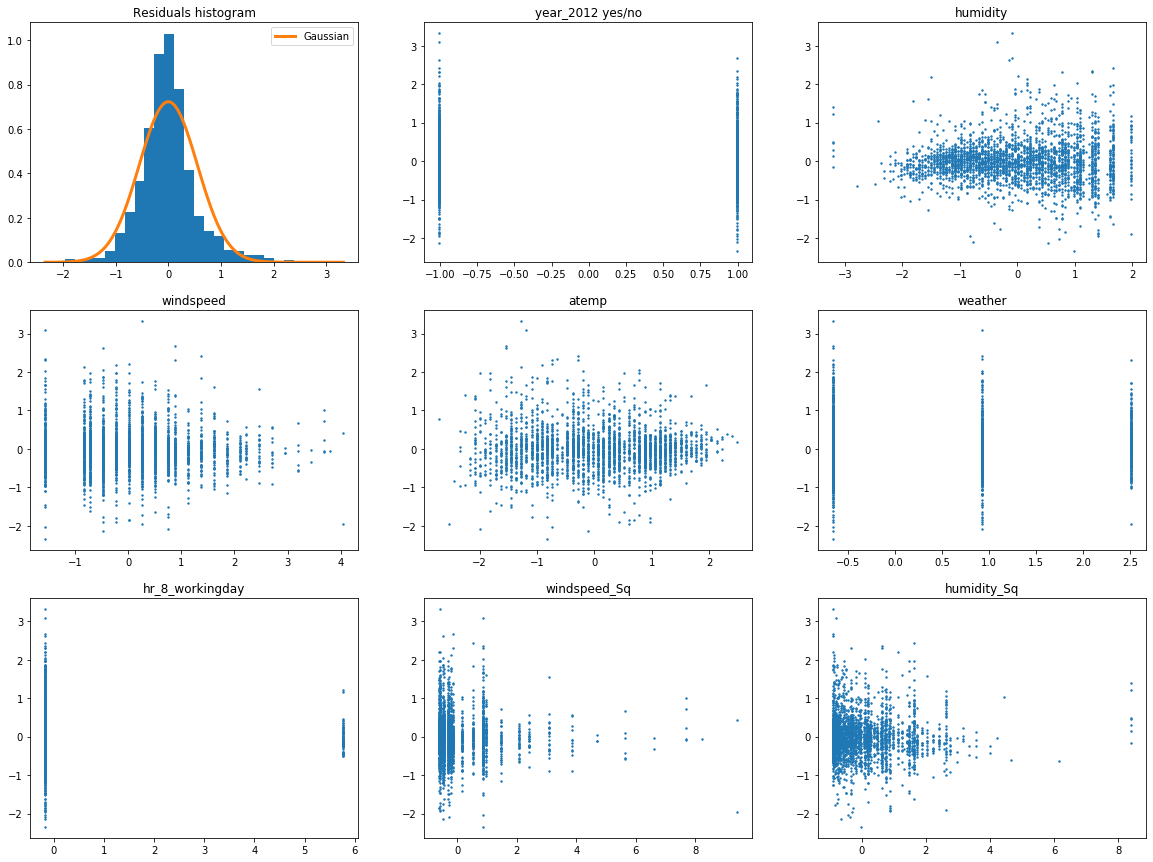

In [10]:
func.plot_diagnostics_lr(df_pred, X_test_fe)

## 7. Verify assumption: predictors are uncorrelated
- Pair-wise correlations between weather and humidity are large
- Pair-wise correlations between humidity/windspeed and their respective second order terms are large

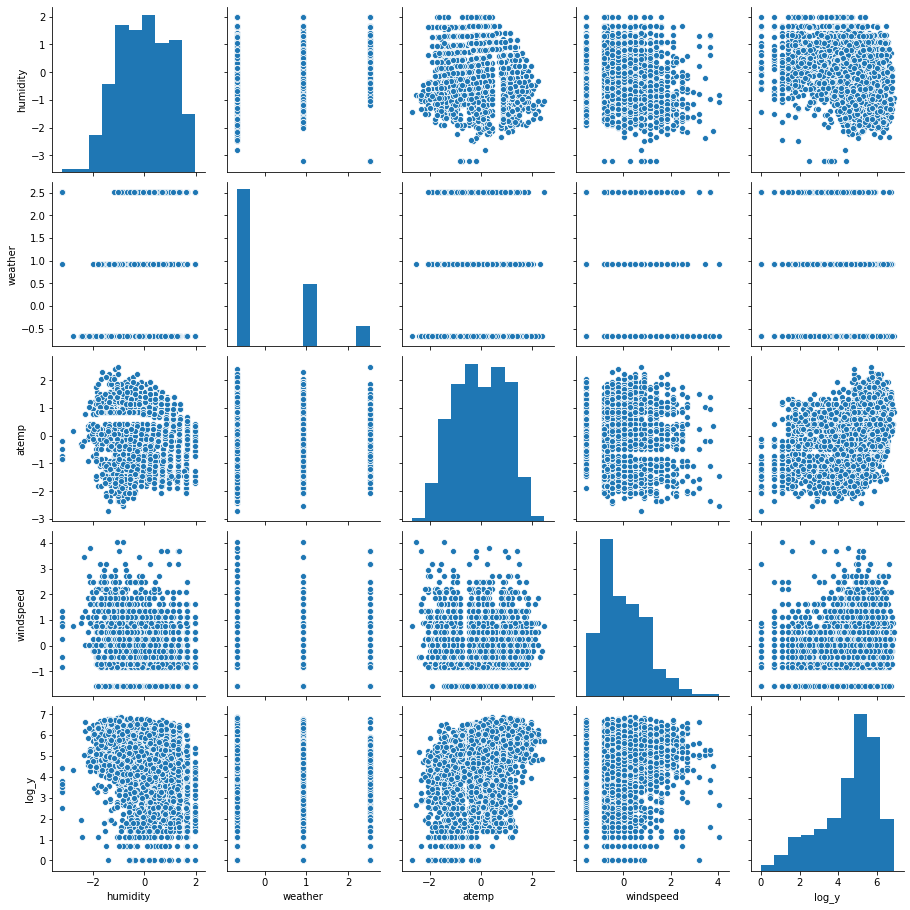

In [11]:
pairs = X_test_fe
pairs['y'] = y_test
pairs['log_y'] = np.log(y_test)

sns.pairplot(X_test_fe[['humidity', 'weather', 'atemp', 'windspeed','log_y']])

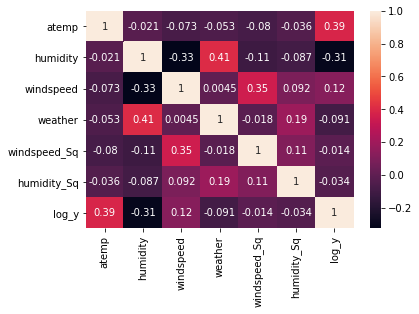

In [12]:
sns.heatmap(pairs[['atemp','humidity', "windspeed", "weather", "windspeed_Sq", "humidity_Sq", "log_y"]].corr(), annot=True)

## 8. Conclusions
- Although we have observed in ols_linear_regression.ipynb that linear regression based on ordinary least squares produces fairly good results, this analysis shows that key assumptions behind OLS linear regression are being violated
- This points towards some promising improvements of the model: 
    - use a generalized linear model such as a Poisson Regressor instead of OLS
    - apply a transformation of weather variables
    - drop correlated variables, e.g. by applying a lasso regression which prefers solutions with fewer non-zero coefficients